In [1]:
from osgeo import gdal
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tif_class = r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\MLSC\MLSC0517_2021-08-22_4074_S2DL.tif'
dataset = gdal.Open(tif_class)
bandclass = dataset.GetRasterBand(1)
dataclass = bandclass.ReadAsArray()
dataclass.astype('int16')  # 设置分类后的数据类型
width = dataset.RasterXSize
height = dataset.RasterYSize
projection = dataset.GetProjection()
geotransform = dataset.GetGeoTransform()
print('完成！！！')

完成！！！


In [3]:
classic = dataclass.reshape(-1)

In [4]:
dfndvi = pd.DataFrame()
ProFiles = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDVI')
for item in tqdm(ProFiles):
    if item.lower().endswith('.tif'):
        src = (r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDVI\\{}'.format(item))
        dataset = gdal.Open(src)
        ndvi_data = dataset.GetRasterBand(1).ReadAsArray()
        ndvi_data = np.nan_to_num(ndvi_data, nan=999)
        dfndvi[item[9:14]] = (ndvi_data.reshape(-1))
dfndvit = dfndvi.T
dfndvit['x'] = range(6)

100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


In [5]:
dfndgi = pd.DataFrame()
ProFiles = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDGI')
for item in tqdm(ProFiles):
    if item[-4:] == '.tif':
        src = (r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDGI\\{}'.format(item))
        dataset = gdal.Open(src)
        ndgi_data = dataset.GetRasterBand(1).ReadAsArray()
        ndgi_data = np.nan_to_num(ndgi_data, nan=999)
        dfndgi[item[9:14]] = (ndgi_data.reshape(-1))
dfndgit = dfndgi.T
dfndgit['x'] = range(6)

100%|██████████| 6/6 [01:16<00:00, 12.80s/it]


In [6]:
dfrvi = pd.DataFrame()
ProFiles = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\RVI')
for item in tqdm(ProFiles):
    if item[-4:] == '.tif':
        src = (r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\RVI\\{}'.format(item))
        dataset = gdal.Open(src)
        rvi_data = dataset.GetRasterBand(1).ReadAsArray()
        rvi_data = np.nan_to_num(rvi_data, nan=999)
        dfrvi[item[8:13]] = (rvi_data.reshape(-1))
dfrvit = dfrvi.T
dfrvit['x'] = range(6)

100%|██████████| 6/6 [00:24<00:00,  4.01s/it]


In [8]:
#过滤筛选
x_data = dfndvit['x'].values
NDGI_data = []
for i in tqdm(range(dfndvit.shape[1] - 1)):
    tmp = dfndvit[i].values
    NDGI_data.append(tmp)
ndvi = pd.DataFrame(NDGI_data)

100%|██████████| 30827488/30827488 [11:40<00:00, 43976.89it/s] 


In [8]:
# ndvi

,0,1,2,3,4,5
0,999.000000,999.000000,999.000000,999.0,999.000000,999.0
1,999.000000,999.000000,999.000000,999.0,999.000000,999.0
2,999.000000,999.000000,999.000000,999.0,999.000000,999.0
3,999.000000,999.000000,999.000000,999.0,999.000000,999.0
4,999.000000,999.000000,999.000000,999.0,999.000000,999.0
...,...,...,...,...,...,...
30827483,0.375835,0.651291,0.680247,999.0,0.463628,999.0
30827484,0.366527,0.664491,0.661950,999.0,0.499560,999.0
30827485,0.346989,0.784159,0.784093,999.0,0.568000,999.0
30827486,0.352095,0.817058,0.865755,999.0,0.646474,999.0


In [7]:
ndvi1=dfndvit.T.head(-1)

In [9]:
mask1 = np.where(((ndvi[3] + ndvi[5]) > 2 * ndvi[4]), 3, 0)
mask1  #玉米
mask2 = np.where(((ndvi[3] + ndvi[5]) < 2 * ndvi[4]), 2, 0)
mask2  #水稻
mask_union = mask1 + mask2

In [10]:
slope_ndvi = []
for item in tqdm(NDGI_data):
    tmp1 = np.gradient(item, x_data)
    slope_ndvi.append(tmp1)
s_ndgi = pd.DataFrame(slope_ndvi)
mask22=np.where(s_ndgi[5]>-0.12,1,0)

100%|██████████| 30827488/30827488 [12:48<00:00, 40096.28it/s]


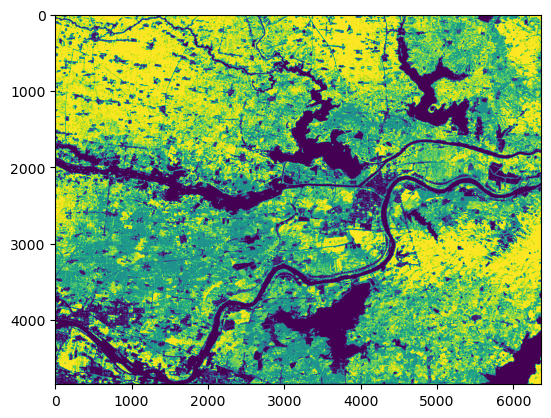

In [11]:
mask_corn = np.where(((classic == 0) & (mask_union == 3)), 3, 0)
mask_rice = np.where(((classic == 0) & (mask_union == 2)), 2, 0)
mask11 = mask_corn + mask_rice
mask=np.where(((mask11==3)&(mask22==1)),4,mask11)
band = mask.reshape((height, width))
plt.imshow(band)
plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\result0518.png', dpi=600)

In [12]:
#导出结果
result_path = r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\result05181455.tif'
target_ds = gdal.GetDriverByName('GTiff').Create(result_path, xsize=width, ysize=height, bands=1,
                                                 eType=gdal.GDT_Int16)
target_ds.SetGeoTransform(dataset.GetGeoTransform())
target_ds.SetProjection(dataset.GetProjection())
del dataset
target_ds.GetRasterBand(1).SetNoDataValue(9999)
target_ds.GetRasterBand(1).WriteArray(band)
target_ds.FlushCache()